In [137]:
%load_ext autoreload
%autoreload
import sys, os
import numpy as np
import scipy.optimize as optimize
import scipy.fftpack as fft
import scipy.linalg as linalg

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from BandPass import *
from fitFunctions import *

#import matlab.engine
#eng = matlab.engine.start_matlab()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
dirName = "/home/jean/RomalisResearch/ncrescini/18-10-30 1/"
files = [f for f in os.listdir(dirName) if f.endswith('.txt')]
gHe = 20378.9
gNe = 2*np.pi*336.1
gRatio = gHe/gNe

ks1 = 3
ks2 = 40
n_ave = 10

dt = 1e-3*n_ave
Fs = 1/dt
D1Start = 50
D1EndTimes = [95]
D2Start = 200
D2EndTimes = [240]
curve_fit = True
calcJac = False

n_subs = 12

In [196]:
bounds_fixfreq = ( ( -3, 3), (-1.5,1.5), (-1,1), (-1,1) )
bounds = ( ( -3, 3), (-1.5,1.5), (0, 3), (-1,1), (-1,1), (10,20) )

bounds_fixfreq_cf = [ [ -3, -1.5, -1, -1 ], [ 3, 1.5, 1, 1 ] ]
bounds_cf = [ [ -3, -1.5, 0, -1, -1, 10 ], [ 3, 1.5, 3, 1, 1, 20 ] ]

In [197]:
for k_ind in range(ks1, ks2+1):
    if "34" not in files[k_ind]: 
        continue
    paraOut = np.array([1.1, 1.1, 0.5, 0.5 ])
    k = k_ind + ks1 - 1
    data = np.loadtxt(dirName+"/"+files[k_ind])
    data = data[:int(np.floor(len(data)/n_ave)*n_ave)]
    data = np.mean( data.reshape(-1, n_ave), axis=1 )
    times = np.arange( 1, len(data)+1, 1 )*dt
    DStart = D1Start
    DEnd = D1EndTimes[np.mod(k_ind-1,len(D2EndTimes))]
    ind_DStart = np.argmin( np.abs(times - DStart) )+1
    ind_DEnd = np.argmin( np.abs(times - DEnd) )
    datafit = np.array([ times[ind_DStart:ind_DEnd] - times[ind_DEnd-1], data[ind_DStart:ind_DEnd] - np.mean(data[ind_DStart:ind_DEnd]) ])
    paraOut = optimize.minimize( lambda para: least_sq(datafit[1], fitSine2Slope([para[0], para[1], 1.5554, para[2], para[3], 15.008], datafit[0])), [ paraOut[0], paraOut[1], paraOut[2], paraOut[3] ], method="SLSQP", bounds=bounds_fixfreq, options={'eps': 1e-12} ).x
    paraOut = optimize.minimize( lambda para: least_sq(datafit[1], fitSine2Slope(para, datafit[0])), [ paraOut[0], paraOut[1], 1.5554, paraOut[2], paraOut[3], 15.008 ], method="SLSQP", bounds=bounds, options={'eps': 1e-12} ).x
    datafit = BandPassFilter(datafit, dt, paraOut, 10, 2)
    paraOut = optimize.minimize( lambda para: least_sq(datafit[1], fitSine2Slope(para, datafit[0])), paraOut, method="SLSQP", bounds=bounds, options={'eps': 1e-12} ).x
    
    ## Partial Fitting
    NPoints = len(datafit[0])
    nPoints = int(np.floor(NPoints/n_subs))
    dataPar_x = datafit[0][:nPoints*n_subs]
    dataPar_y = datafit[1][:nPoints*n_subs]
    dataPar_x = np.reshape(dataPar_x, [n_subs, nPoints])
    dataPar_y = np.reshape(dataPar_y, [n_subs, nPoints])
    paraOut_arr = []
    errtout_arr = []
    errtout_arr2= []
    datafit2 = []
    for i in range(n_subs):
        dataPar_x0 = dataPar_x[i] - min(dataPar_x[i])
        fitResult = optimize.minimize( lambda para: least_sq(dataPar_y[i], fitSine2Slope([para[0], para[1], 1.5554, para[2], para[3], 15.008], dataPar_x0)), [ paraOut[0], paraOut[1], paraOut[3], paraOut[4]], method="SLSQP", bounds=bounds_fixfreq, options={'eps': 1e-12, 'maxiter': 10000} )
        fitResult = optimize.minimize( lambda para: least_sq(dataPar_y[i], fitSine2Slope(para, dataPar_x0)), [ fitResult.x[0], fitResult.x[1], 1.5554, fitResult.x[3], fitResult.x[3], 15.008], method="SLSQP", bounds=bounds, options={'eps': 1e-12, 'maxiter': 10000} )
        
        if curve_fit:
            fitResult = optimize.curve_fit( lambda xdata, *para: fitSine2Slope(para, xdata), dataPar_x0, dataPar_y[i], fitResult.x, bounds=bounds_cf, gtol=2.220446049250313e-16, ftol=2.220446049250313e-16, xtol=2.220446049250313e-16)
            #fitResult = optimize.least_squares( lambda xdata, *para: fitSine2Slope(para, xdata), dataPar_x[i], dataPar_y[i], x0=fitResult.x, bounds=bounds, gtol=2.220446049250313e-16, ftol=2.220446049250313e-16, xtol=2.220446049250313e-16)
            paraOut = fitResult[0]
            datafit2.extend(fitSine2Slope(paraOut, dataPar_x0))
            errtout = np.sqrt(np.diag(fitResult[1]))
        else:
            fitResult = optimize.minimize( lambda para: least_sq(dataPar_y[i], fitSine2Slope(para, dataPar_x0)), fitResult.x, method="SLSQP", bounds=bounds, options={'eps': 1e-12} )
            paraOut = fitResult.x
            datafit2.extend(fitSine2Slope(paraOut, dataPar_x0))
            
        if calcJac or (not curve_fit): 
            if (not curve_fit) and (not calcJac): J = np.array([fitResult.jac])
            else: J = np.array([np.sum(np.array(Jacobian( paraOut, dataPar_x0 )).T, axis=0)])
            rechi2 = np.sum( (fitSine2Slope(paraOut, dataPar_x0) - dataPar_y[i])**2/len(dataPar_x - len(paraOut)))
            resigma = np.sqrt(rechi2)
            alpha = np.matmul( J.T, J )/resigma**2
            erroralpha = alpha
            errtout = np.sqrt(np.diag(erroralpha))
            
        paraOut_arr.append([ 
            np.sqrt(paraOut[0]**2 + paraOut[1]**2), paraOut[2], np.arctan2(paraOut[1], paraOut[0]),
            np.sqrt(paraOut[3]**2 + paraOut[4]**2), paraOut[5], np.arctan2(paraOut[4], paraOut[3])
        ])
        errtout_arr.append([
            paraOut_arr[-1][0]**(-1) * np.sqrt( (errtout[0]/paraOut[0])**2 + (errtout[1]/paraOut[1])**2 ), 
            errtout[2], 
            np.abs(paraOut[0]*paraOut[1])/paraOut_arr[-1][0]**2 * np.sqrt( (errtout[0]/paraOut[0])**2 + (errtout[1]/paraOut[1])**2 ),
            paraOut_arr[-1][3]**(-1) * np.sqrt( (errtout[3]/paraOut[3])**2 + (errtout[4]/paraOut[4])**2 ), 
            errtout[5], 
            np.abs(paraOut[3]*paraOut[4])/paraOut_arr[-1][3]**2 * np.sqrt( (errtout[3]/paraOut[3])**2 + (errtout[4]/paraOut[4])**2 ),
        ])
errtout_arr = np.array(errtout_arr)
paraOut_arr = np.array(paraOut_arr)

/home/jean/RomalisResearch/pulsed_fitter_current/BandPass.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
  fftdata = np.zeros((2,Lfilt))


(-40, -30)

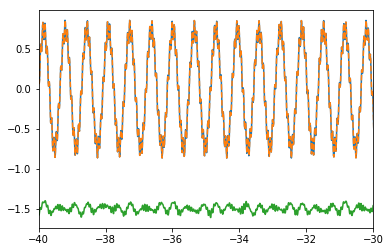

In [198]:
plt.plot(dataPar_x.flatten(), (dataPar_y).flatten())
plt.plot(dataPar_x.flatten(), datafit2, ls="--")
plt.plot(dataPar_x.flatten(), 100*(datafit2-(dataPar_y).flatten())-1.5)
plt.xlim([-40,-30])

<Container object of 3 artists>

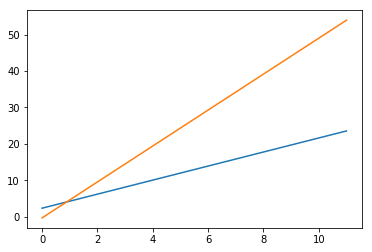

In [211]:
phi1_arr = paraOut_arr[:,2].copy()
for i in range(1, len(phi1_arr)):
    while phi1_arr[i] - phi1_arr[i-1] < 0.1:
         phi1_arr[i]= phi1_arr[i]+2*np.pi

phi2_arr = np.flip(paraOut_arr[:,5]).copy()
for i in range(1, len(phi2_arr)):
    while phi2_arr[i] - phi2_arr[i-1] < 0.1:
         phi2_arr[i]= phi2_arr[i]+2*np.pi

plt.errorbar( np.arange(len(phi1_arr)), phi1_arr, errtout_arr[:,2] )
plt.errorbar( np.arange(len(phi2_arr)), phi2_arr, errtout_arr[:,5] )

In [159]:
        J = np.array([ fitResult.jac ]) #np.sum(np.array(Jacobian( paraOut, dataPar_x[i] )).T, axis=0)
        rechi2 = np.sum( (fitSine2Slope(paraOut, dataPar_x[i]) - dataPar_y[i])**2/len(dataPar_x - len(paraOut)))
        resigma = np.sqrt(rechi2)
        alpha = np.matmul( J.T, J )
        #eng.workspace['J'] = matlab.double(J.tolist())
        #eng.workspace['mat'] = matlab.double(alpha.tolist())
        #print(alpha)
        #erroralpha = np.asarray(eng.eval("ones(4,4)\mat"))
        erroralpha = linalg.inv(alpha)